In [1]:
# %% [markdown]
# # Jupyter Notebook Loading Header
#
# This is a custom loading header for Jupyter Notebooks in Visual Studio Code.
# It includes common imports and settings to get you started quickly.

# %% [markdown]
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import os
path = r'C:\Users\DwaipayanChakroborti\AppData\Roaming\gcloud\legacy_credentials\dchakroborti@tonikbank.com\adc.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path
client = bigquery.Client(project='prj-prod-dataplatform')

# %% [markdown]
## Configure Settings
# Set options or configurations as needed
# Example: pd.set_option('display.max_columns', None)

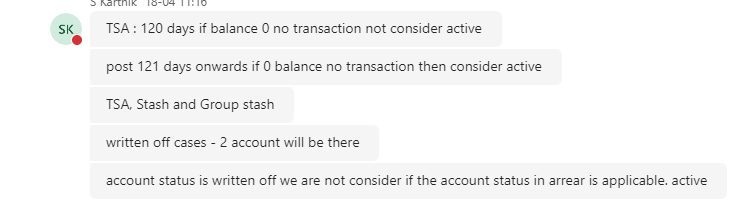

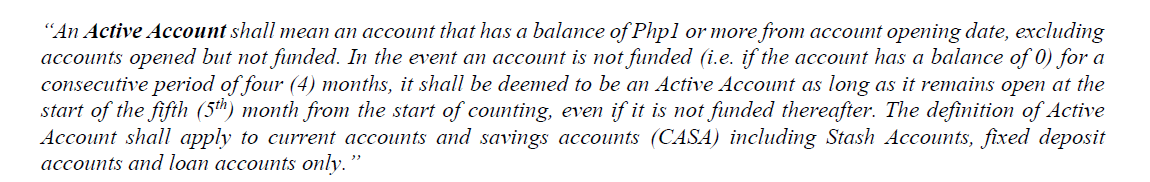

In [2]:
sq = """select CASE 
WHEN CRINTERDESC = 'Transactional Savings Account Inv_R' THEN 'TSA'
ELSE CRINTERDESC
END AS OFPRODUCTCATEGORY, 
count(distinct OFSTANDARDACCOUNTID) cnt from core_raw.customer_accounts 
where  OFDATECLOSED = DATE '1970-01-01' #OR OFDATECLOSED > DATE '2023-05-31' 
and CRINTERDESC IN ('Transactional Savings Account Inv_R','Stash Account Inv_R','Group stash Account_R')
group by 1;"""

df1 = client.query(sq).to_dataframe()
df1

,OFPRODUCTCATEGORY,cnt
0,Group stash Account_R,23617
1,TSA,580062
2,Stash Account Inv_R,145520


## TSA Accounts which had balance = 0 within 120 days of account opening and is not closed

In [3]:
sq = """select ACCOUNTPRODUCT_ACCPRODID 
from
(
select  b1.ACCOUNTPRODUCT_ACCPRODID 
, sum(case when date(TRANSACTIONDATE) between date(OFDATEOPENED) and date_add(date(OFDATEOPENED), interval 120 day) and OFDATECLOSED = DATE '1970-01-01' 
            and CRINTERDESC IN ('Transactional Savings Account Inv_R') then OFCLEAREDBALANCE else 0 end) balancewithin4months
, sum(case when date(TRANSACTIONDATE) > date_add(date(OFDATEOPENED), interval 120 day) and OFDATECLOSED = DATE '1970-01-01'
           and CRINTERDESC IN ('Transactional Savings Account Inv_R') then OFCLEAREDBALANCE else 0 end) balanceoutside4months
from `core_raw.casa_account_transactions` b1
left join `core_raw.customer_accounts` b2 on b1.ACCOUNTPRODUCT_ACCPRODID = b2.OFSTANDARDACCOUNTID
group by 1
)
where balancewithin4months > 0
"""

df2 = client.query(sq).to_dataframe()
len(df2)

183793

# An account that has PHP >= 1 from account opening day and thereafter

In [4]:
sq = """
select CASE 
WHEN CRINTERDESC = 'Transactional Savings Account Inv_R' THEN 'TSA'
ELSE CRINTERDESC
END AS OFPRODUCTCATEGORY, 
count(distinct OFSTANDARDACCOUNTID) cnt 
from core_raw.customer_accounts ca
where CRINTERDESC IN ('Transactional Savings Account Inv_R','Stash Account Inv_R','Group stash Account_R') and OFDATECLOSED = DATE '1970-01-01'
and OFSTANDARDACCOUNTID in 
(select ACCOUNTPRODUCT_ACCPRODID 
from
(
select  b1.ACCOUNTPRODUCT_ACCPRODID 
, sum(case when date(TRANSACTIONDATE) between date(OFDATEOPENED) and date_add(date(OFDATEOPENED), interval 120 day) and OFDATECLOSED = DATE '1970-01-01' 
            and CRINTERDESC IN ('Transactional Savings Account Inv_R','Stash Account Inv_R','Group stash Account_R') then OFCLEAREDBALANCE else 0 end) balancewithin4months
, sum(case when date(TRANSACTIONDATE) > date_add(date(OFDATEOPENED), interval 120 day) and OFDATECLOSED = DATE '1970-01-01'
           and CRINTERDESC IN ('Transactional Savings Account Inv_R','Stash Account Inv_R','Group stash Account_R') then OFCLEAREDBALANCE else 0 end) balanceoutside4months
from `core_raw.casa_account_transactions` b1
left join `core_raw.customer_accounts` b2 on b1.ACCOUNTPRODUCT_ACCPRODID = b2.OFSTANDARDACCOUNTID
group by 1
)
where balancewithin4months >= 1)
group by 1
;"""

df3 = client.query(sq).to_dataframe()

In [5]:
df3

,OFPRODUCTCATEGORY,cnt
0,Stash Account Inv_R,32341
1,Group stash Account_R,16753
2,TSA,168259
